# Segment Anything with TensorFlow & Keras


In [1]:
# !pip install -U tensorflow_hub transformers

In [2]:
from transformers import (
    TFSamModel, 
    SamProcessor
)
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import tensorflow_hub as hub
import requests
import zipfile
import os

2025-03-07 10:51:46.570234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 10:51:46.578520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741324906.588402   39295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741324906.591469   39295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 10:51:46.601556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Download the Inference Dataset

In [3]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [4]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
save_name = "sam_infer_input.zip"

if not os.path.exists(save_name):
    download_file(
        "https://www.dropbox.com/scl/fi/301ah7zj4iolt9e4x0y2x/sam_infer_input.zip?rlkey=p9ktqv6y70kbbidfsgs75qh9p&st=vrwd09cw&dl=1",
        save_name
    )

    unzip(zip_file=save_name)

## Loading the TensorFlow SAM Model

In [6]:
model = TFSamModel.from_pretrained('facebook/sam-vit-base')
processor = SamProcessor.from_pretrained('facebook/sam-vit-base')

I0000 00:00:1741324908.116514   39295 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5285 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [7]:
np_config.enable_numpy_behavior()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

def show_multibox_masks(raw_image, masks, scores):
    """
    This function handles overlaying the mask on images when 
    multiple boxes are detected.
    """
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    axes.imshow(np.array(raw_image))
    for current_mask, current_score in zip(final_masks, final_scores):
        mask = tf.stop_gradient(current_mask[0])
        show_mask(mask, axes)
        axes.axis("off")
    plt.show()

def show_masks_on_image(raw_image, masks, scores):
    """
    This function handles overlaying the mask on image for single points, 
    multiple points, and single bounding boxes.
    """
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

Let's load and display the image that will be used throughout this tutorial.

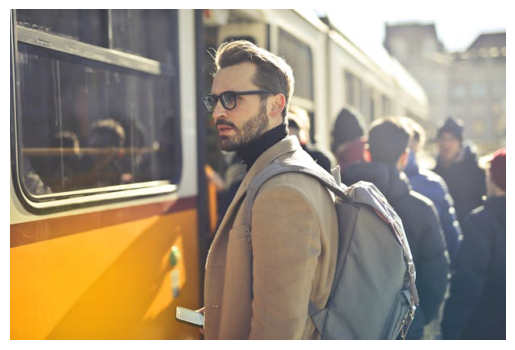

In [8]:
image = Image.open('sam_infer_input/image_1.jpg').convert('RGB')
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
print(image.size)

(640, 427)


In [10]:
input_points = [[[350, 250], [600, 300]]]

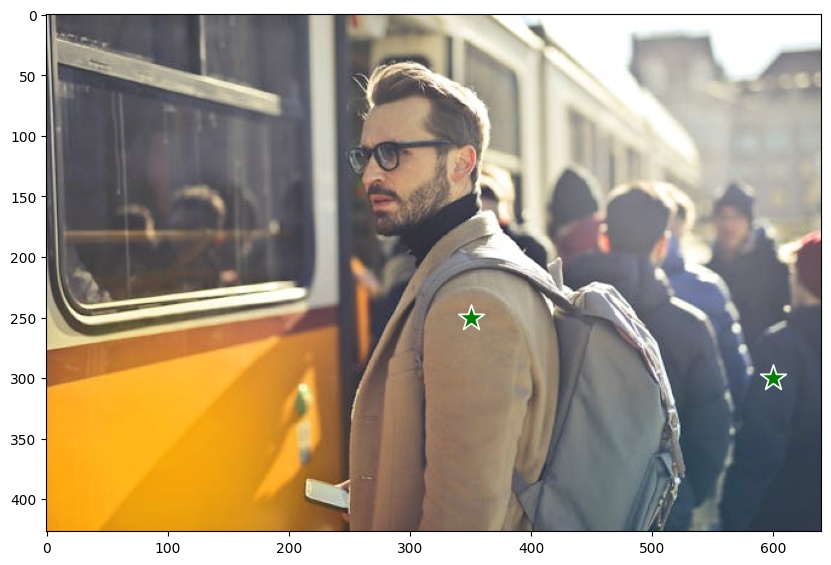

In [11]:
show_points_on_image(image, input_points[0])

In [12]:
inputs = processor(image, input_points=input_points, return_tensors='tf')
outputs = model(**inputs)

/home/sovit/miniconda3/envs/tf_218/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
I0000 00:00:1741324910.473304   39295 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [13]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs['original_sizes'],
    inputs['reshaped_input_sizes'],
    return_tensors='tf',
)

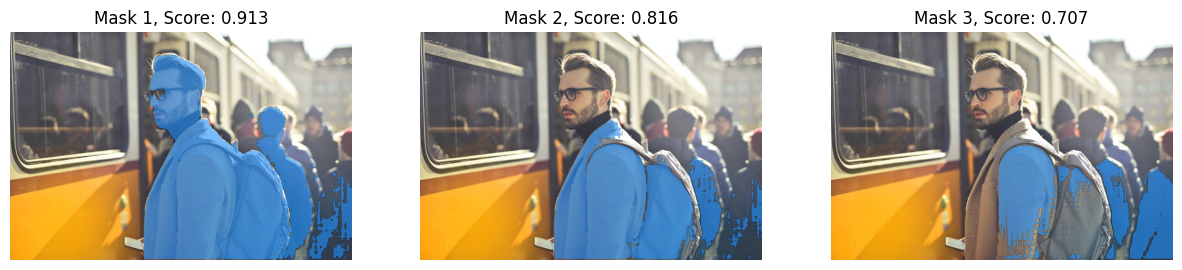

In [14]:
show_masks_on_image(image, masks, outputs.iou_scores)

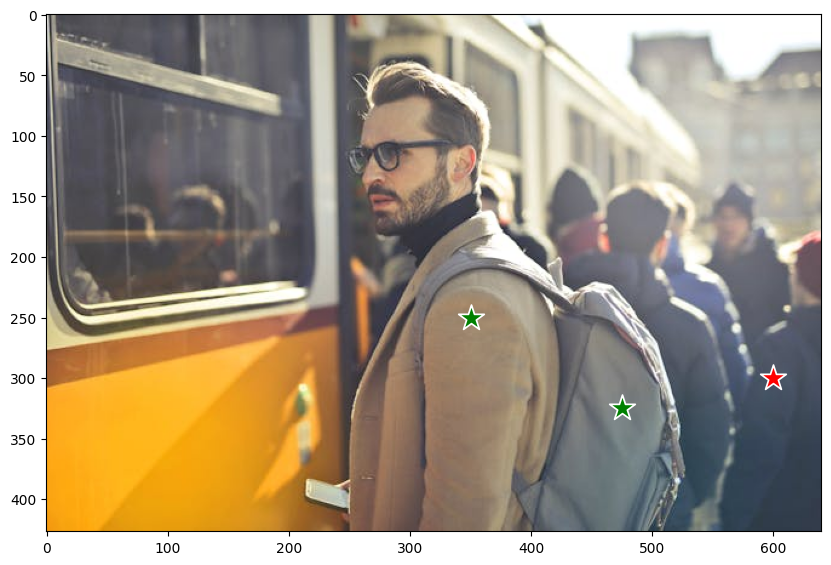

In [15]:
input_points = [[[350, 250], [475, 325], [600, 300]]]

input_labels = [[1, 1, 0]]

show_points_on_image(image, input_points[0], input_labels=input_labels[0])

In [16]:
inputs = processor(
    image, 
    input_points=input_points, 
    input_labels=input_labels, 
    return_tensors='tf'
)
outputs = model(**inputs)

In [17]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs['original_sizes'],
    inputs['reshaped_input_sizes'],
    return_tensors='tf',
)

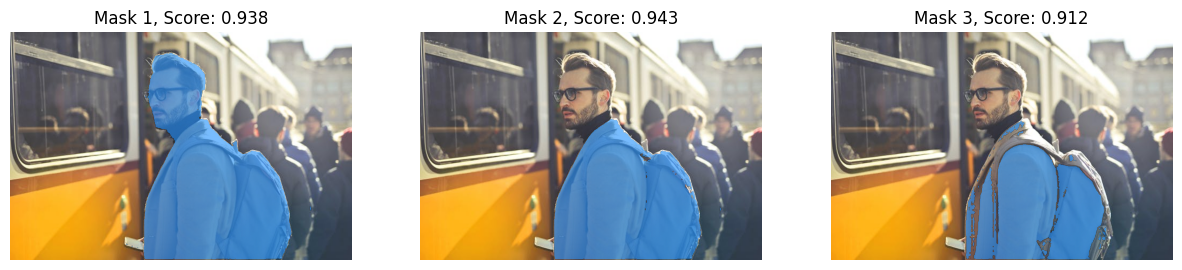

In [18]:
show_masks_on_image(image, masks, outputs.iou_scores)

In [19]:
bboxes = [[[390, 220, 530, 425]]]

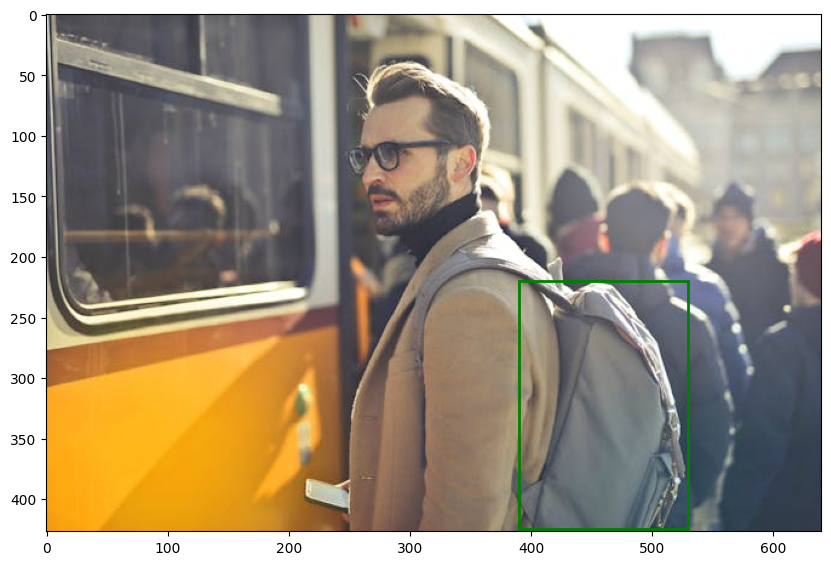

In [20]:
show_boxes_on_image(image, bboxes[0])

In [21]:
inputs = processor(image, input_boxes=bboxes, return_tensors='tf')
outputs = model(**inputs)

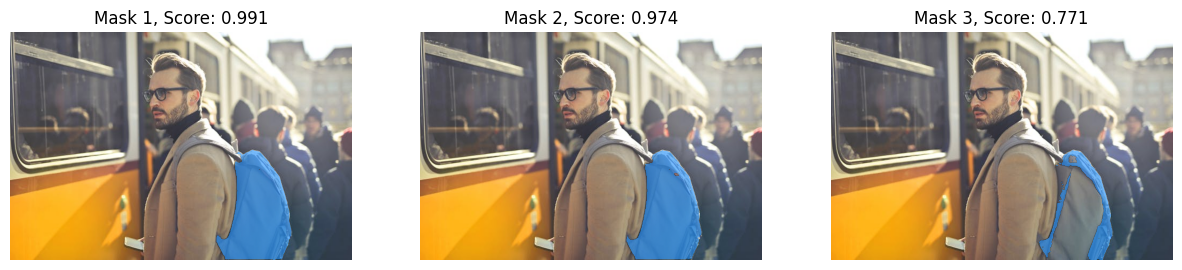

In [22]:
masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs['original_sizes'],
    inputs['reshaped_input_sizes'],
    return_tensors='tf',
)

show_masks_on_image(image, masks, outputs.iou_scores)

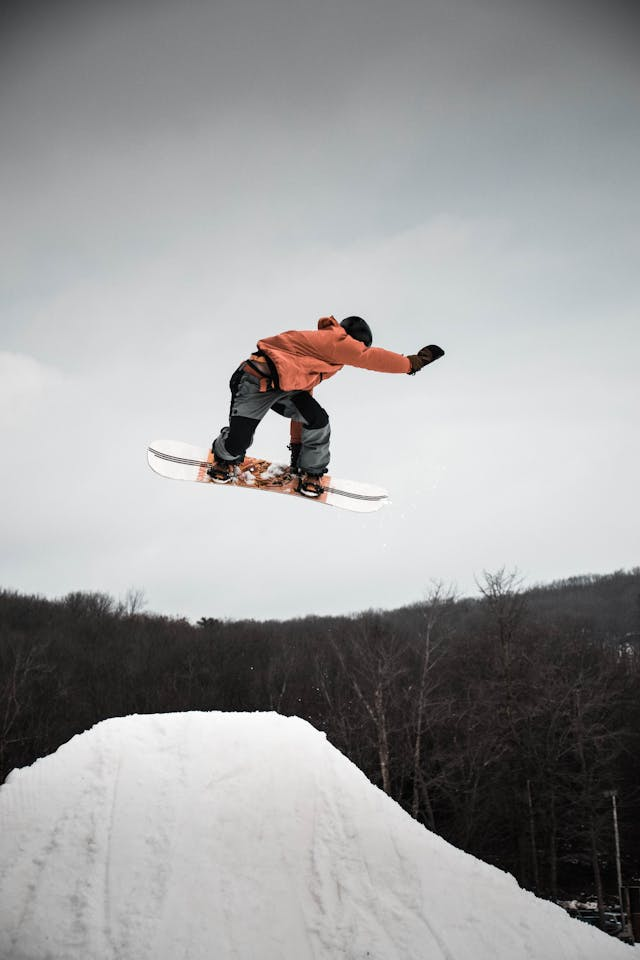

In [23]:
image = Image.open('sam_infer_input/image_2.jpg')
image

In [24]:
effdet_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite2-detection/versions/1")

In [25]:
tf_image = tf.constant(image, dtype=tf.uint8)
tf_image = tf.expand_dims(tf_image, axis=0)
image_np = tf_image.numpy()

In [26]:
# Run forward pass.
boxes, scores, classes, num_detections = effdet_model(image_np)

In [27]:
# Helper function for annotation.
def annotate_image(img, boxes, scores, num_detections, score_threshold=0.5):
    image = np.array(img)

    bboxes_list = []

    for i in range(num_detections):
        if scores[i] >= score_threshold:
            box = boxes[i]
            
            y_min, x_min, y_max, x_max = box

            bboxes_list.append([int(x_min), int(y_min), int(x_max), int(y_max)])

            cv2.rectangle(
                image, 
                (int(x_min), int(y_min)), 
                (int(x_max), int(y_max)), 
                (0, 255, 0), 2
            )

    return image, bboxes_list

In [28]:
img, bboxes_list = annotate_image(image_np[0], boxes[0], scores[0], num_detections[0])

(np.float64(-0.5), np.float64(639.5), np.float64(959.5), np.float64(-0.5))

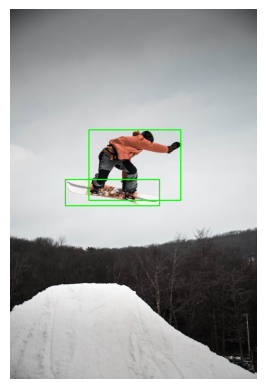

In [29]:
plt.imshow(img)
plt.axis('off')

In [30]:
print(bboxes_list)

[[204, 313, 442, 496], [143, 442, 387, 510]]


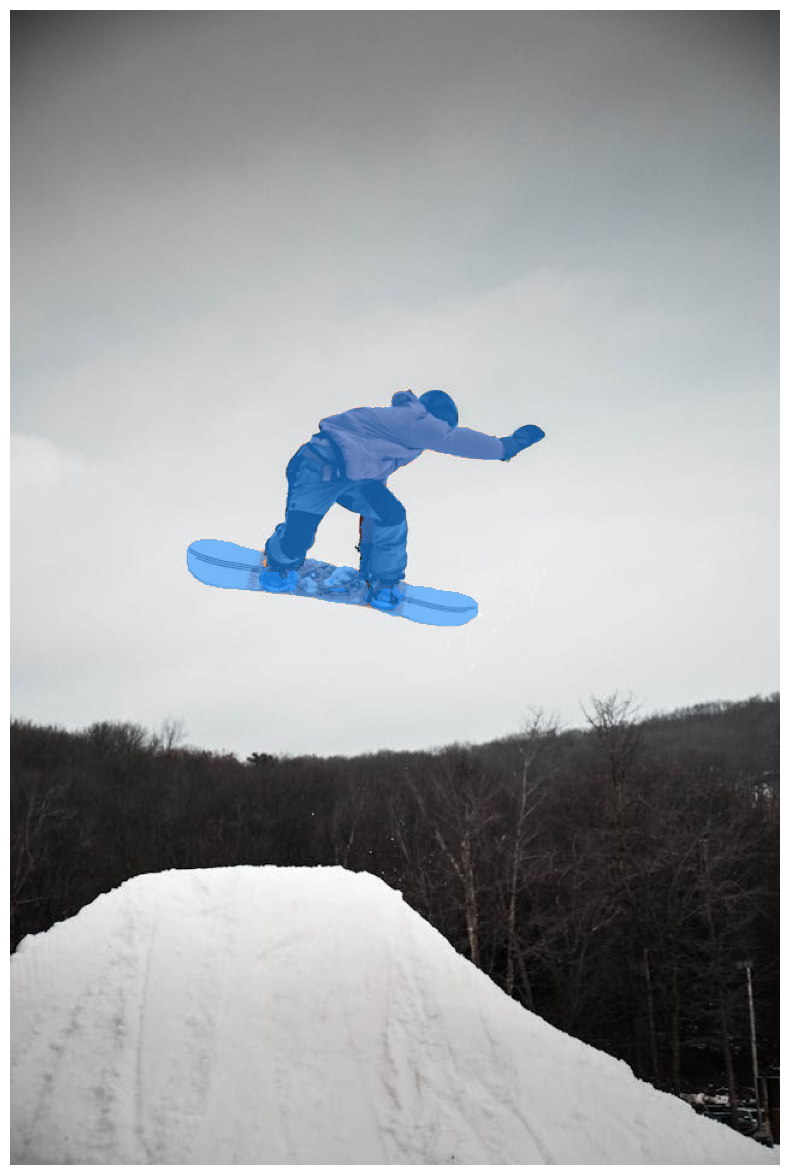

In [31]:
bboxes = [[bboxes_list]]

inputs = processor(image, input_boxes=bboxes, return_tensors='tf')
outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs['original_sizes'],
    inputs['reshaped_input_sizes'],
    return_tensors='tf',
)

show_multibox_masks(image, masks, outputs.iou_scores)